In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras import models,layers,Sequential
from sklearn.model_selection import train_test_split

In [20]:
tf.test.is_gpu_available()

True

In [21]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [22]:
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * 16
EPOCHS = 50
output_size=len(class_names)
input_shape=(208, 176, 3)

In [23]:
path=r"G:\dataset\Alzheimer_s Dataset"

In [24]:
trainData=[]
trainDataLables=[]
for name in class_names:
    images = [cv2.imread(file) for file in glob.glob(path+"\\train\\"+name+r'\*.jpg')]
    for i in images:
        trainData.append(np.array(i).reshape((208, 176, 3)))
        trainDataLables.append(name)


trainData=np.asarray(trainData)
trainDataLables=np.asarray(trainDataLables)

In [25]:
lableId=[]
for i in range(len(trainDataLables)):
    for j in range(len(class_names)):
        if trainDataLables[i]==class_names[j]:
            lableId.append(j)

trainLables=tf.keras.utils.to_categorical(lableId, num_classes=len(class_names), dtype='float32')

In [26]:
x_train,x_val,y_train,y_val=train_test_split(trainData, trainLables, test_size=0.2, random_state=42)

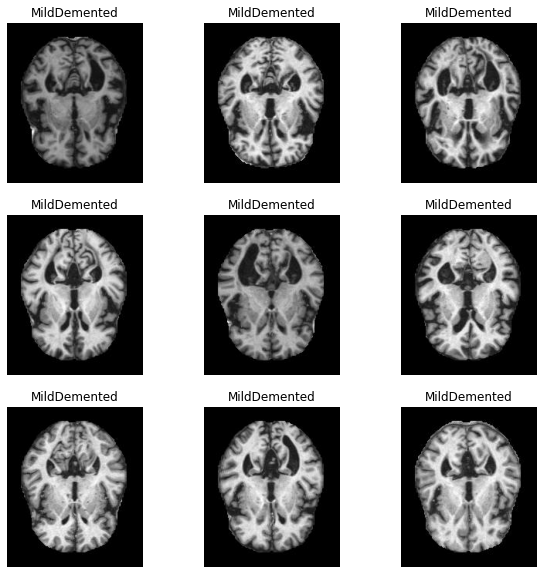

In [27]:
plt.figure(figsize=(10, 10))
i=0
for x in range(9):
    ax = plt.subplot(3, 3, i+1)
    i+=1
    plt.imshow(trainData[x])
    plt.title(trainDataLables[x])
    plt.axis("off")

In [28]:
def conv_block(filters):
    block = Sequential([
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D()
    ]
    )
    
    return block

In [29]:
def dense_block(units, dropout_rate):
    block = Sequential([
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate)
    ])
    
    return block

In [30]:
model = models.Sequential([
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu',input_shape=input_shape),
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu'),
    layers.MaxPooling2D(),


    conv_block(32),
    conv_block(64),
        
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    dense_block(512, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    layers.Dense(output_size, activation='softmax')
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 202, 170, 16)      2368      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 196, 164, 16)      12560     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 98, 82, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 49, 41, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 24, 20, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 12, 10, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 10, 128)     

In [31]:
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=METRICS
    )

In [32]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [33]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS,verbose=2
)

Train on 4096 samples, validate on 1025 samples
Epoch 1/50
4096/4096 - 130s - loss: 1.1474 - auc: 0.7688 - val_loss: 6.2936 - val_auc: 0.6586
Epoch 2/50
4096/4096 - 126s - loss: 0.9663 - auc: 0.8138 - val_loss: 1.0220 - val_auc: 0.7994
Epoch 3/50
4096/4096 - 126s - loss: 0.9525 - auc: 0.8176 - val_loss: 1.1022 - val_auc: 0.7600
Epoch 4/50
4096/4096 - 126s - loss: 0.9340 - auc: 0.8250 - val_loss: 4.7791 - val_auc: 0.7420
Epoch 5/50
4096/4096 - 126s - loss: 0.9220 - auc: 0.8326 - val_loss: 1.2878 - val_auc: 0.6562
Epoch 6/50
4096/4096 - 127s - loss: 0.9162 - auc: 0.8334 - val_loss: 7.2917 - val_auc: 0.6693
Epoch 7/50
4096/4096 - 126s - loss: 0.9119 - auc: 0.8369 - val_loss: 1.3876 - val_auc: 0.6353
Epoch 8/50
4096/4096 - 127s - loss: 0.9242 - auc: 0.8340 - val_loss: 16.1862 - val_auc: 0.6592
Epoch 9/50
4096/4096 - 127s - loss: 0.9360 - auc: 0.8239 - val_loss: 1.9714 - val_auc: 0.7811
Epoch 10/50
4096/4096 - 127s - loss: 0.9263 - auc: 0.8258 - val_loss: 1.0190 - val_auc: 0.8180
Epoch 11/5

In [34]:
model.save(path+"\\alzheimer_model_trained.h5")

In [35]:
# model = models.load_model(path+r"\trained.h5")
testData=[]
testDataLables=[]
for name in class_names:
    images = [cv2.imread(file) for file in glob.glob(path+"\\test\\"+name+r'\*.jpg')]
    for i in images:
        testData.append(np.array(i).reshape((208, 176, 3)))
        testDataLables.append(name)


testData=np.asarray(testData)
testDataLables=np.asarray(testDataLables)



testlableId=[]
for i in range(len(testDataLables)):
    for j in range(len(class_names)):
        if testDataLables[i]==class_names[j]:
            testlableId.append(j)

testLables=tf.keras.utils.to_categorical(testlableId, num_classes=len(class_names), dtype='float32')

In [36]:
model.evaluate(testData, testLables)

1279/1279 [==============================] - 5s 4ms/sample - loss: 0.9042 - auc: 0.8699


[0.9041730627778735, 0.8698957]